## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Pitching\\trad\Dataframes\\pitchfinal2.csv"

try:
    df = pd.read_csv(file_path, encoding='latin1')
except UnicodeDecodeError:
    print("Error reading the file with 'latin1' encoding.")
    
df.head()


,Name,Date,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,HLD_2,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2
0,Jay Jackson,2024,1,1.5,1.5,0.0,0.0,1.0,MIN,TOR,...,0.0,1.1,1.0,6.750002,0.000000,0.000000,0,0.333333333,0.666666666,92.600000
1,Gerardo Reyes,2024,1,NaN,0.0,1.0,0.0,1.0,OAK,LAA,...,0.0,2.0,0.0,0.000000,13.500000,4.500000,0.111111111,0.222222222,0.666666666,96.611111
2,Arodys Vizcaino,2022,1,1.0,1.0,1.0,0.0,1.0,KCR,NYM,...,0.0,4.0,6.0,13.500000,6.750000,2.250000,0.125,0.125,0.75,95.972222
3,Tyler White,2022,1,NaN,0.0,1.0,0.0,1.0,MIL,TOR,...,0.0,3.1,2.0,5.400002,13.500005,10.800004,0.133333333,0.133333333,0.733333333,78.079365
4,Reymin Guduan,2020,1,NaN,0.0,1.0,0.0,1.0,LAD,HOU,...,0.0,3.1,4.0,10.800001,0.000000,2.700000,0.142857142,0,0.857142857,95.272727


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              1093 non-null   object 
 1   Date              1093 non-null   int64  
 2   contract_years    1093 non-null   int64  
 3   salary            586 non-null    float64
 4   AAV               1092 non-null   float64
 5   minor_league      1089 non-null   float64
 6   SP                1091 non-null   float64
 7   RP                1090 non-null   float64
 8   new_team          1093 non-null   object 
 9   former_team       1093 non-null   object 
 10  Age               1093 non-null   int64  
 11  bWAR3             1093 non-null   float64
 12  Yrs               1093 non-null   int64  
 13  stayed_same_team  1090 non-null   float64
 14  W                 918 non-null    float64
 15  L                 918 non-null    float64
 16  ERA               918 non-null    float64


In [4]:
df2 = df.rename(columns={'Date':'year'})
df2.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,HLD_2,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2
0,Jay Jackson,2024,1,1.5,1.5,0.0,0.0,1.0,MIN,TOR,...,0.0,1.1,1.0,6.750002,0.000000,0.000000,0,0.333333333,0.666666666,92.600000
1,Gerardo Reyes,2024,1,NaN,0.0,1.0,0.0,1.0,OAK,LAA,...,0.0,2.0,0.0,0.000000,13.500000,4.500000,0.111111111,0.222222222,0.666666666,96.611111
2,Arodys Vizcaino,2022,1,1.0,1.0,1.0,0.0,1.0,KCR,NYM,...,0.0,4.0,6.0,13.500000,6.750000,2.250000,0.125,0.125,0.75,95.972222
3,Tyler White,2022,1,NaN,0.0,1.0,0.0,1.0,MIL,TOR,...,0.0,3.1,2.0,5.400002,13.500005,10.800004,0.133333333,0.133333333,0.733333333,78.079365
4,Reymin Guduan,2020,1,NaN,0.0,1.0,0.0,1.0,LAD,HOU,...,0.0,3.1,4.0,10.800001,0.000000,2.700000,0.142857142,0,0.857142857,95.272727


#### The Shohei Ohtani case. 


As explained in the batters notebook, Ohtani is not being paid just to be a batter or a pitcher. He is elite in both, making him the highest paid player, in terms of AAV. The mentioned notebook has a more detailed explanation of the situation and how I am planning to solve it. In short terms I am dividing his total WAR3, which is the accumulated Wins Above Replacement of the last 3 years (28.5) and separating it into the amount that corresponds to pitching and the rest that corresponds to batting. 14.3 belongs to Offensive WAR and 14.2 belongs to Pitching War. This means that 0.501754386 is for OWAR and 0.49824562 is for PWAR. Thats how Ohtanis AAV will be taken into account. 

In [5]:
shohei_index = df2.index[df2['Name'] == 'Shohei Ohtani'].tolist()[0]
df2.loc[shohei_index, 'salary'] *= 0.49824562
df2.loc[shohei_index, 'AAV'] *= 0.49824562

In [6]:
df2.loc[shohei_index, 'bWAR3'] = 14.2

In [7]:
df2.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,HLD_2,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2
0,Jay Jackson,2024,1,1.5,1.5,0.0,0.0,1.0,MIN,TOR,...,0.0,1.1,1.0,6.750002,0.000000,0.000000,0,0.333333333,0.666666666,92.600000
1,Gerardo Reyes,2024,1,NaN,0.0,1.0,0.0,1.0,OAK,LAA,...,0.0,2.0,0.0,0.000000,13.500000,4.500000,0.111111111,0.222222222,0.666666666,96.611111
2,Arodys Vizcaino,2022,1,1.0,1.0,1.0,0.0,1.0,KCR,NYM,...,0.0,4.0,6.0,13.500000,6.750000,2.250000,0.125,0.125,0.75,95.972222
3,Tyler White,2022,1,NaN,0.0,1.0,0.0,1.0,MIL,TOR,...,0.0,3.1,2.0,5.400002,13.500005,10.800004,0.133333333,0.133333333,0.733333333,78.079365
4,Reymin Guduan,2020,1,NaN,0.0,1.0,0.0,1.0,LAD,HOU,...,0.0,3.1,4.0,10.800001,0.000000,2.700000,0.142857142,0,0.857142857,95.272727


### Handling the NULL values. 

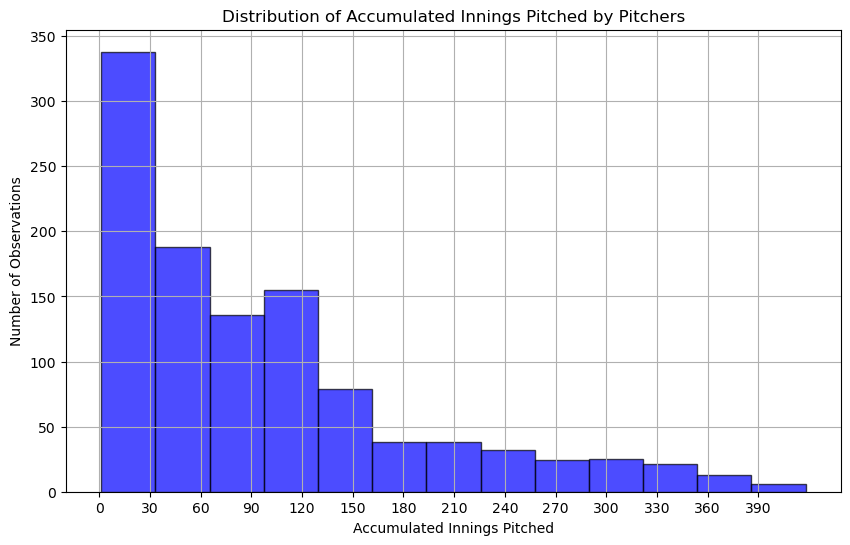

In [8]:
if 'IP' in df2.columns and 'IP_2' in df2.columns:
    df2['IP'] = pd.to_numeric(df2['IP'], errors='coerce')
    df2['IP_2'] = pd.to_numeric(df2['IP_2'], errors='coerce')
    
    df2['IP'] = df2['IP'].fillna(0)
    df2['IP_2'] = df2['IP_2'].fillna(0)
    
    df2['Accumulated_IP'] = df2['IP'] + df2['IP_2']
    
    plt.figure(figsize=(10, 6))
    plt.hist(df2['Accumulated_IP'], bins=int((df2['Accumulated_IP'].max() - df2['Accumulated_IP'].min()) / 30), alpha=0.7, color='b', edgecolor='black')
    plt.xlabel('Accumulated Innings Pitched')
    plt.ylabel('Number of Observations')
    plt.title('Distribution of Accumulated Innings Pitched by Pitchers')
    plt.grid(True)
    plt.xticks(range(0, int(df2['Accumulated_IP'].max()) + 1, 30))  # Set xticks every 30
    plt.show()
else:
    print("The columns 'IP' and/or 'IP_2' do not exist in the DataFrame.")

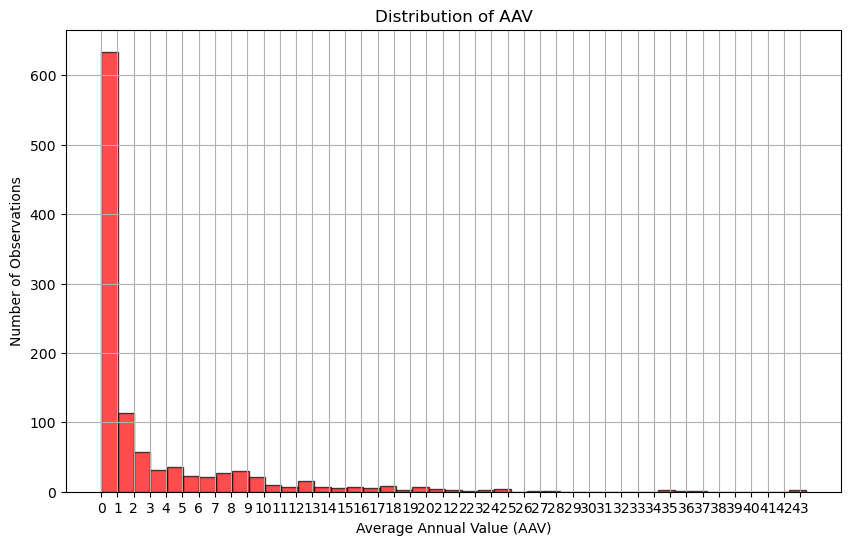

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df2['AAV'], bins=int(df2['AAV'].max()) - int(df2['AAV'].min()), alpha=0.7, color='r', edgecolor='black')
plt.xlabel('Average Annual Value (AAV)')
plt.ylabel('Number of Observations')
plt.title('Distribution of AAV')
plt.grid(True)
plt.xticks(range(int(df2['AAV'].min()), int(df2['AAV'].max()) + 1))  # Set xticks every 1
plt.show()

In [10]:
filtered_df = df2[(df2['AAV'] < .720) & (df2['minor_league'] == 1)] ## 720k is the common minor league deal given. Some players negotiate a deal with a higher salary, indicating better performance, longevity or that teams see something more in them. Those I rather keep.


num_observations = filtered_df.shape[0]

print("Number of observations with AAV less than 1 and are minor leaguers:", num_observations)


Number of observations with AAV less than 1 and are minor leaguers: 541


I will remove pitchers that didn't complete 30 Innings pitchs between the two seasons (IP and IP_2). Most of them are minor leaguers that received the same salary (720k). This doesnt help our predictions as much. 


In [11]:
df3 = df2[~((df2['AAV'] < .720) & (df2['minor_league'] == 1))]

df3.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
0,Jay Jackson,2024,1,1.500,1.500,0.0,0.0,1.0,MIN,TOR,...,1.1,1.0,6.750002,0.000000,0.00,0,0.333333333,0.666666666,92.600000,30.3
2,Arodys Vizcaino,2022,1,1.000,1.000,1.0,0.0,1.0,KCR,NYM,...,4.0,6.0,13.500000,6.750000,2.25,0.125,0.125,0.75,95.972222,4.0
5,Nick Anderson,2023,1,0.875,0.875,0.0,0.0,1.0,ATL,TBR,...,6.0,1.0,1.500000,3.000000,3.00,0.15,0.15,0.7,93.000000,6.0
6,Shelby Miller,2024,1,3.250,3.250,0.0,0.0,1.0,DET,LAD,...,7.0,14.0,18.000002,3.857143,0.00,0.153846153,0.384615384,0.461538461,94.421053,49.0
9,Noah Syndergaard,2023,1,13.000,13.000,0.0,1.0,0.0,LAD,PHI,...,2.0,2.0,9.000000,0.000000,4.50,0.166666666,0.333333333,0.5,94.733333,136.2


In [12]:
df3.shape[0]

552

In [13]:
df3.describe()

,year,contract_years,salary,AAV,minor_league,SP,RP,Age,bWAR3,Yrs,...,SV_2,BS_2,HLD_2,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP
count,552.000000,552.000000,545.000000,551.000000,548.000000,551.000000,552.000000,552.000000,552.000000,552.000000,...,509.000000,509.000000,509.000000,552.000000,509.000000,509.000000,509.000000,509.000000,508.000000,552.000000
mean,2020.846014,1.548913,14.709398,6.116021,0.218978,0.399274,0.702899,32.489130,2.465217,8.414855,...,3.978389,1.538310,5.082515,73.239837,77.495088,8.823854,3.289549,1.162517,92.843910,144.710127
std,2.454638,1.113096,32.437327,6.615497,0.413932,0.490194,0.457396,3.011151,2.719638,3.232660,...,8.916361,2.055578,7.518027,55.824413,53.623014,2.295935,1.406239,0.661905,2.711746,94.987109
min,2017.000000,1.000000,0.600000,0.000000,0.000000,0.000000,0.000000,24.000000,-2.400000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,0.000000,0.000000,81.500000,1.000000
25%,2019.000000,1.000000,1.500000,1.500000,0.000000,0.000000,0.000000,30.000000,0.700000,6.000000,...,0.000000,0.000000,0.000000,34.100000,39.000000,7.309393,2.370000,0.771429,91.363168,80.075000
50%,2022.000000,1.000000,4.000000,3.500000,0.000000,0.000000,1.000000,32.000000,1.900000,8.000000,...,0.000000,0.000000,1.000000,61.600000,66.000000,8.688119,3.100000,1.113402,92.902479,120.400000
75%,2023.000000,2.000000,14.000000,8.500000,0.000000,1.000000,1.000000,34.000000,3.400000,11.000000,...,2.000000,3.000000,8.000000,105.425000,100.000000,10.193879,4.010000,1.430000,94.700000,199.400000
max,2024.000000,10.000000,348.771934,43.333333,1.000000,1.000000,1.000000,45.000000,16.800000,20.000000,...,51.000000,8.000000,40.000000,223.000000,300.000000,18.000002,10.800000,6.570000,99.500000,418.100000


In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 1092
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              552 non-null    object 
 1   year              552 non-null    int64  
 2   contract_years    552 non-null    int64  
 3   salary            545 non-null    float64
 4   AAV               551 non-null    float64
 5   minor_league      548 non-null    float64
 6   SP                551 non-null    float64
 7   RP                552 non-null    float64
 8   new_team          552 non-null    object 
 9   former_team       552 non-null    object 
 10  Age               552 non-null    int64  
 11  bWAR3             552 non-null    float64
 12  Yrs               552 non-null    int64  
 13  stayed_same_team  549 non-null    float64
 14  W                 523 non-null    float64
 15  L                 523 non-null    float64
 16  ERA               523 non-null    float64
 

In [15]:
df3[df3['minor_league'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
102,Adam Oller,2024,1,0.75,0.75,NaN,0.0,1.0,CLE,SEA,...,74.1,46.0,5.569507,4.721973,2.058296,0.315789473,0.170040485,0.51417004,93.414722,93.3
599,Justin Wilson,2023,1,1.00,NaN,NaN,0.0,1.0,MIL,CIN,...,34.0,29.0,7.680000,4.240000,1.590000,0.465,0.111,0.424,93.600000,37.2
612,Derek Law,2024,1,1.50,1.50,NaN,0.0,1.0,WSN,CIN,...,19.2,17.0,7.779663,3.661018,1.372882,0.46875,0.234375,0.296875,95.171053,74.2
711,Justin Wilson,2024,1,1.50,1.50,NaN,0.0,1.0,CIN,MIL,...,3.2,7.0,17.180000,0.000000,0.000000,0.5,0.167,0.333,95.100000,3.2


In [16]:
players_to_fill = {'Adam Oller': 1, 'Derek Law': 1, 'Justin Wilson': 0}

for player, value in players_to_fill.items():
    df3.loc[df3['Name'] == player, 'minor_league'] = value

print(df3[df3['Name'].isin(['Adam Oller', 'Derek Law', 'Justin Wilson'])])



              Name  year  contract_years  salary   AAV  minor_league   SP  \
102     Adam Oller  2024               1    0.75  0.75           1.0  0.0   
256  Justin Wilson  2019               2   10.00  5.00           0.0  0.0   
511      Derek Law  2023               1    1.00  1.00           1.0  0.0   
599  Justin Wilson  2023               1    1.00   NaN           0.0  0.0   
612      Derek Law  2024               1    1.50  1.50           1.0  0.0   
711  Justin Wilson  2024               1    1.50  1.50           0.0  0.0   

      RP new_team former_team  ...  IP_2  SO_2      K/9_2    BB/9_2    HR/9_2  \
102  1.0      CLE         SEA  ...  74.1  46.0   5.569507  4.721973  2.058296   
256  1.0      NYM         CHC  ...  58.0  80.0  12.410000  5.430000  0.780000   
511  1.0      CIN         CIN  ...  15.0  14.0   8.400002  4.800001  1.200000   
599  1.0      MIL         CIN  ...  34.0  29.0   7.680000  4.240000  1.590000   
612  1.0      WSN         CIN  ...  19.2  17.0   7.7796

In [17]:
df3[df3['salary'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
22,William Cuevas,2018,1,NaN,0.0,0.0,0.0,1.0,BOS,MIA,...,5.0,3.0,5.400000,10.800000,0.000000,0.214285714,0.357142857,0.428571428,90.070175,5.0
104,Jake Odorizzi,2024,1,NaN,0.0,0.0,1.0,0.0,TBR,TEX,...,106.1,86.0,7.278997,2.962383,1.184953,0.31707317,0.216463414,0.466463414,92.099891,106.1
151,Jake Newberry,2022,1,NaN,0.0,0.0,0.0,1.0,PHI,KCR,...,31.0,29.0,8.419354,4.645161,2.032258,0.34065934,0.153846153,0.505494505,93.812721,35.1
757,Williams Perez,2017,1,NaN,0.0,0.0,0.0,1.0,CHC,ATL,...,116.2,73.0,5.631428,3.934285,1.002857,0.509333333,0.202666666,0.288,90.620793,169.4
857,Williams Perez,2018,1,NaN,0.0,0.0,0.0,1.0,CHC,CHC,...,53.2,27.0,4.527951,2.515528,1.173913,0.570652173,0.152173913,0.277173913,91.182250,53.2
1056,Preston Guilmet,2019,1,NaN,0.0,0.0,0.0,1.0,MIN,TOR,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1078,Preston Claiborne,2018,1,NaN,0.0,0.0,0.0,1.0,CLE,TEX,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Odorizzi's salary wasn't in the Spotrac database which is why it is not here, but I know he is still a major league caliber player. I googled his contract and found that he got 1.5M in base salary and 2.5M as incentives. I added both, but this could represent an improvement opportunity for future work. We don't know every detail of every contract. 


I dropped the other players. 

In [18]:
df3.loc[(df3['Name'] == 'Jake Odorizzi') & (df3['year'] == 2024), 'salary'] = 4.00
df3.loc[(df3['Name'] == 'Jake Odorizzi') & (df3['year'] == 2024), 'minor_league'] = 1
df3.loc[(df3['Name'] == 'Jake Odorizzi') & (df3['year'] == 2024), 'AAV'] = 4.00

print(df3[(df3['Name'] == 'Jake Odorizzi')])



              Name  year  contract_years  salary   AAV  minor_league   SP  \
104  Jake Odorizzi  2024               1     4.0   4.0           1.0  1.0   
201  Jake Odorizzi  2020               1    17.8  17.8           0.0  1.0   

      RP new_team former_team  ...   IP_2   SO_2     K/9_2    BB/9_2  \
104  0.0      TBR         TEX  ...  106.1   86.0  7.278997  2.962383   
201  0.0      MIN         MIN  ...  130.2  115.0  7.920000  3.170000   

       HR/9_2       GB%_2        LD%_2        FB%_2      FBv_2  Accumulated_IP  
104  1.184953  0.31707317  0.216463414  0.466463414  92.099891           106.1  
201  1.450000        0.36        0.219         0.42  92.400000           289.2  

[2 rows x 55 columns]


In [19]:
df4 = df3.dropna(subset=['salary'])

df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 1092
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              546 non-null    object 
 1   year              546 non-null    int64  
 2   contract_years    546 non-null    int64  
 3   salary            546 non-null    float64
 4   AAV               545 non-null    float64
 5   minor_league      546 non-null    float64
 6   SP                545 non-null    float64
 7   RP                546 non-null    float64
 8   new_team          546 non-null    object 
 9   former_team       546 non-null    object 
 10  Age               546 non-null    int64  
 11  bWAR3             546 non-null    float64
 12  Yrs               546 non-null    int64  
 13  stayed_same_team  543 non-null    float64
 14  W                 519 non-null    float64
 15  L                 519 non-null    float64
 16  ERA               519 non-null    float64
 

In [20]:
df4[df4['AAV'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
599,Justin Wilson,2023,1,1.0,NaN,0.0,0.0,1.0,MIL,CIN,...,34.0,29.0,7.68,4.24,1.59,0.465,0.111,0.424,93.6,37.2


In [21]:
df4.loc[(df4['Name'] == 'Justin Wilson') & (df4['year'] == 2023), 'AAV'] = 1.00
print(df4[(df4['Name'] == 'Justin Wilson')])

              Name  year  contract_years  salary  AAV  minor_league   SP   RP  \
256  Justin Wilson  2019               2    10.0  5.0           0.0  0.0  1.0   
599  Justin Wilson  2023               1     1.0  1.0           0.0  0.0  1.0   
711  Justin Wilson  2024               1     1.5  1.5           0.0  0.0  1.0   

    new_team former_team  ...  IP_2  SO_2  K/9_2  BB/9_2  HR/9_2  GB%_2  \
256      NYM         CHC  ...  58.0  80.0  12.41    5.43    0.78  0.374   
599      MIL         CIN  ...  34.0  29.0   7.68    4.24    1.59  0.465   
711      CIN         MIL  ...   3.2   7.0  17.18    0.00    0.00    0.5   

     LD%_2  FB%_2  FBv_2  Accumulated_IP  
256  0.183  0.443   96.0           112.2  
599  0.111  0.424   93.6            37.2  
711  0.167  0.333   95.1             3.2  

[3 rows x 55 columns]


In [22]:
df4[df4['SP'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
504,Luis Severino,2024,1,13.0,13.0,0.0,NaN,1.0,NYM,NYY,...,102.0,112.0,9.882353,2.647059,1.235294,0.443137254,0.160784313,0.396078431,96.337469,191.1


In [23]:
df4.loc[(df4['Name'] == 'Luis Severino') & (df4['year'] == 2024), 'SP'] = 1.0
df4.loc[(df4['Name'] == 'Luis Severino') & (df4['year'] == 2024), 'RP'] = 0.0
print(df4[(df4['Name'] == 'Luis Severino')])

              Name  year  contract_years  salary   AAV  minor_league   SP  \
504  Luis Severino  2024               1    13.0  13.0           0.0  1.0   

      RP new_team former_team  ...   IP_2   SO_2     K/9_2    BB/9_2  \
504  0.0      NYM         NYY  ...  102.0  112.0  9.882353  2.647059   

       HR/9_2        GB%_2        LD%_2        FB%_2      FBv_2  \
504  1.235294  0.443137254  0.160784313  0.396078431  96.337469   

     Accumulated_IP  
504           191.1  

[1 rows x 55 columns]


In [24]:
df4[df4['stayed_same_team'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
248,Sergio Romo,2019,1,2.5,2.5,0.0,0.0,1.0,MIA,TBR,...,55.2,59.0,9.54,3.07,1.46,0.372,0.2,0.428,86.1,122.3
807,Dakota Hudson,2024,1,1.5,1.5,0.0,1.0,0.0,COL,STL,...,139.2,78.0,5.03,3.93,0.58,0.53,0.189,0.281,91.8,220.3
899,Joe Kelly,2022,2,17.0,8.5,0.0,0.0,1.0,CHW,LAD,...,51.1,62.0,10.87,3.86,1.05,0.612,0.216,0.173,98.0,95.1


In [25]:
df5 = df4.copy()

df5['stayed_same_team'].fillna(0, inplace=True)

df5[df5['stayed_same_team'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP


In [26]:
df5['Total_IP'] = df5['IP'] + df5['IP_2']
mask = df5['Total_IP'] >= 30

df_filtered = df5[mask]

df6=df_filtered.copy()

In [27]:
len(df5) - len(df_filtered)

38

In [28]:
df6.drop('Total_IP', axis=1, inplace=True)

df6.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
0,Jay Jackson,2024,1,1.50,1.50,0.0,0.0,1.0,MIN,TOR,...,1.1,1.0,6.750002,0.000000,0.000000,0,0.333333333,0.666666666,92.600000,30.3
6,Shelby Miller,2024,1,3.25,3.25,0.0,0.0,1.0,DET,LAD,...,7.0,14.0,18.000002,3.857143,0.000000,0.153846153,0.384615384,0.461538461,94.421053,49.0
9,Noah Syndergaard,2023,1,13.00,13.00,0.0,1.0,0.0,LAD,PHI,...,2.0,2.0,9.000000,0.000000,4.500000,0.166666666,0.333333333,0.5,94.733333,136.2
15,Sean Doolittle,2023,1,1.50,1.50,1.0,0.0,1.0,WSN,WSN,...,49.2,53.0,9.604029,4.167786,1.268457,0.190140845,0.267605633,0.542253521,93.139601,54.3
16,Tyler Clippard,2020,1,2.75,2.75,0.0,0.0,1.0,MIN,CLE,...,68.2,85.0,11.140778,3.014564,1.703884,0.191860465,0.203488372,0.604651162,90.926531,130.2


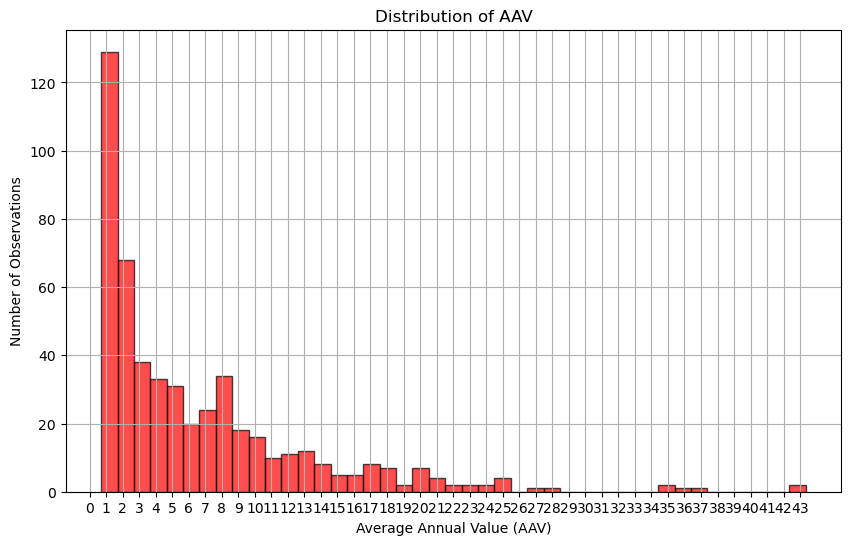

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(df6['AAV'], bins=int(df2['AAV'].max()) - int(df6['AAV'].min()), alpha=0.7, color='r', edgecolor='black')
plt.xlabel('Average Annual Value (AAV)')
plt.ylabel('Number of Observations')
plt.title('Distribution of AAV')
plt.grid(True)
plt.xticks(range(int(df6['AAV'].min()), int(df6['AAV'].max()) + 1))  # Set xticks every 1
plt.show()

In [30]:
df6['minor_league'].sum()

98.0

In [31]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   contract_years    508 non-null    int64  
 3   salary            508 non-null    float64
 4   AAV               508 non-null    float64
 5   minor_league      508 non-null    float64
 6   SP                508 non-null    float64
 7   RP                508 non-null    float64
 8   new_team          508 non-null    object 
 9   former_team       508 non-null    object 
 10  Age               508 non-null    int64  
 11  bWAR3             508 non-null    float64
 12  Yrs               508 non-null    int64  
 13  stayed_same_team  508 non-null    float64
 14  W                 491 non-null    float64
 15  L                 491 non-null    float64
 16  ERA               491 non-null    float64
 

In [32]:
df6[df6['PlayerId'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
703,Will Harris,2020,3,24.0,8.0,0.0,0.0,1.0,WSN,HOU,...,56.2,64.0,10.164709,2.22353,0.476471,0.496598639,0.265306122,0.238095238,92.333333,116.2


In [33]:
df6.loc[(df6['Name'] == 'Will Harris') & (df6['year'] == 2020), 'PlayerId'] = 3192
df6.loc[(df6['Name'] == 'Will Harris') & (df6['year'] == 2020), 'MLBAMID'] = 501789
print(df6[(df6['Name'] == 'Will Harris')])

            Name  year  contract_years  salary  AAV  minor_league   SP   RP  \
703  Will Harris  2020               3    24.0  8.0           0.0  0.0  1.0   

    new_team former_team  ...  IP_2  SO_2      K/9_2   BB/9_2    HR/9_2  \
703      WSN         HOU  ...  56.2  64.0  10.164709  2.22353  0.476471   

           GB%_2        LD%_2        FB%_2      FBv_2  Accumulated_IP  
703  0.496598639  0.265306122  0.238095238  92.333333           116.2  

[1 rows x 55 columns]


In [34]:
players_with_text_values = ['Scott Alexander', 'Tanner Roark', 'Wade Miley']
rows_with_text_values = df6[df6['Name'].isin(players_with_text_values)]

columns_to_show = ['Name','year','GB%_2', 'LD%_2', 'FB%_2']
text_values_and_columns = rows_with_text_values[columns_to_show]

print(text_values_and_columns)


                Name  year  GB%_2  LD%_2  FB%_2
633       Wade Miley  2018  0.473  0.225  0.302
697       Wade Miley  2023  0.494  0.235  0.271
740       Wade Miley  2019  0.503  0.229  0.268
799       Wade Miley  2024  0.526   0.14  0.333
928  Scott Alexander  2024   0.74   0.14   0.12
929     Tanner Roark  2020  40.7%  21.7%  37.6%
930       Wade Miley  2020  52.8%  23.6%  23.6%


In [35]:
columns_to_convert = ['GB%_2', 'LD%_2', 'FB%_2']

def convert_percent_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for column in columns_to_convert:
    df6[column] = df6[column].apply(convert_percent_to_float)

rows_with_text_values_updated = df6[df6['Name'].isin(players_with_text_values)][['Name', 'year'] + columns_to_convert]
print(rows_with_text_values_updated)


                Name  year  GB%_2  LD%_2  FB%_2
633       Wade Miley  2018  0.473  0.225  0.302
697       Wade Miley  2023  0.494  0.235  0.271
740       Wade Miley  2019  0.503  0.229  0.268
799       Wade Miley  2024  0.526   0.14  0.333
928  Scott Alexander  2024   0.74   0.14   0.12
929     Tanner Roark  2020  0.407  0.217  0.376
930       Wade Miley  2020  0.528  0.236  0.236


In [36]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   contract_years    508 non-null    int64  
 3   salary            508 non-null    float64
 4   AAV               508 non-null    float64
 5   minor_league      508 non-null    float64
 6   SP                508 non-null    float64
 7   RP                508 non-null    float64
 8   new_team          508 non-null    object 
 9   former_team       508 non-null    object 
 10  Age               508 non-null    int64  
 11  bWAR3             508 non-null    float64
 12  Yrs               508 non-null    int64  
 13  stayed_same_team  508 non-null    float64
 14  W                 491 non-null    float64
 15  L                 491 non-null    float64
 16  ERA               491 non-null    float64
 

In [37]:
columns_to_convert = ['GB%_2', 'LD%_2', 'FB%_2']

def convert_percent_to_float(value):
    if isinstance(value, str):
        value = value.strip()  
        if '%' in value:
            value = value.replace('%', '')  
        try:
            return float(value)
        except ValueError:
            return None 
    return value

for column in columns_to_convert:
    df6[column] = df6[column].apply(convert_percent_to_float)

df6[columns_to_convert] = df6[columns_to_convert].astype(float)

rows_with_text_values_updated = df6[df6['Name'].isin(players_with_text_values)][['Name', 'year'] + columns_to_convert]
print(rows_with_text_values_updated)


                Name  year  GB%_2  LD%_2  FB%_2
633       Wade Miley  2018  0.473  0.225  0.302
697       Wade Miley  2023  0.494  0.235  0.271
740       Wade Miley  2019  0.503  0.229  0.268
799       Wade Miley  2024  0.526  0.140  0.333
928  Scott Alexander  2024  0.740  0.140  0.120
929     Tanner Roark  2020  0.407  0.217  0.376
930       Wade Miley  2020  0.528  0.236  0.236


In [38]:
df6.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
0,Jay Jackson,2024,1,1.50,1.50,0.0,0.0,1.0,MIN,TOR,...,1.1,1.0,6.750002,0.000000,0.000000,0.000000,0.333333,0.666667,92.600000,30.3
6,Shelby Miller,2024,1,3.25,3.25,0.0,0.0,1.0,DET,LAD,...,7.0,14.0,18.000002,3.857143,0.000000,0.153846,0.384615,0.461538,94.421053,49.0
9,Noah Syndergaard,2023,1,13.00,13.00,0.0,1.0,0.0,LAD,PHI,...,2.0,2.0,9.000000,0.000000,4.500000,0.166667,0.333333,0.500000,94.733333,136.2
15,Sean Doolittle,2023,1,1.50,1.50,1.0,0.0,1.0,WSN,WSN,...,49.2,53.0,9.604029,4.167786,1.268457,0.190141,0.267606,0.542254,93.139601,54.3
16,Tyler Clippard,2020,1,2.75,2.75,0.0,0.0,1.0,MIN,CLE,...,68.2,85.0,11.140778,3.014564,1.703884,0.191860,0.203488,0.604651,90.926531,130.2


In [39]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   contract_years    508 non-null    int64  
 3   salary            508 non-null    float64
 4   AAV               508 non-null    float64
 5   minor_league      508 non-null    float64
 6   SP                508 non-null    float64
 7   RP                508 non-null    float64
 8   new_team          508 non-null    object 
 9   former_team       508 non-null    object 
 10  Age               508 non-null    int64  
 11  bWAR3             508 non-null    float64
 12  Yrs               508 non-null    int64  
 13  stayed_same_team  508 non-null    float64
 14  W                 491 non-null    float64
 15  L                 491 non-null    float64
 16  ERA               491 non-null    float64
 

For players that have last season complete, but have the second to last as NULL, I will fill the NULL columns with next season's values. For example IP_2 with IP.
For players that have last season as NULL, but HAVE the second to last full, I will fill the columns with the median of that column. This would assume that the missed season for a player was played at a 50 percentile level. 


I don't want to lose some players that got a heavy contract but lost a season becasue of injury. Some teams bet on very good players coming back from big injuries.

In [40]:
columns = ['W', 'L', 'ERA', 'WHIP', 'G', 'GS', 'QS', 'SV', 'BS', 'HLD', 'IP', 'SO', 'K/9', 'BB/9', 'HR/9', 'GB%', 'LD%', 'FB%', 'FBv']

for column in columns:
    column_2 = f"{column}_2"
    
    df6.loc[df6[column_2].isnull() & df6[column].notnull(), column_2] = df6.loc[df6[column_2].isnull() & df6[column].notnull(), column]

    median_value = df6[column].median()
    df6.loc[df6[column].isnull() & df6[column_2].notnull(), column] = median_value

print(df6[columns + [f"{col}_2" for col in columns]].head())


       W     L       ERA      WHIP     G    GS   QS   SV   BS  HLD  ...  \
0    3.0   1.0  2.123596  0.910112  25.0   0.0  0.0  0.0  0.0  1.0  ...   
6    3.0   0.0  1.714286  0.904762  36.0   1.0  0.0  1.0  0.0  3.0  ...   
9   10.0  10.0  3.943070  1.254951  25.0  24.0  9.0  0.0  0.0  0.0  ...   
15   0.0   0.0  0.000000  0.187500   6.0   0.0  0.0  0.0  0.0  2.0  ...   
16   1.0   0.0  2.903227  0.854839  53.0   3.0  0.0  0.0  0.0  8.0  ...   

    HLD_2  IP_2  SO_2      K/9_2    BB/9_2    HR/9_2     GB%_2     LD%_2  \
0     0.0   1.1   1.0   6.750002  0.000000  0.000000  0.000000  0.333333   
6     1.0   7.0  14.0  18.000002  3.857143  0.000000  0.153846  0.384615   
9     0.0   2.0   2.0   9.000000  0.000000  4.500000  0.166667  0.333333   
15    5.0  49.2  53.0   9.604029  4.167786  1.268457  0.190141  0.267606   
16   15.0  68.2  85.0  11.140778  3.014564  1.703884  0.191860  0.203488   

       FB%_2      FBv_2  
0   0.666667  92.600000  
6   0.461538  94.421053  
9   0.500000  

In [41]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   contract_years    508 non-null    int64  
 3   salary            508 non-null    float64
 4   AAV               508 non-null    float64
 5   minor_league      508 non-null    float64
 6   SP                508 non-null    float64
 7   RP                508 non-null    float64
 8   new_team          508 non-null    object 
 9   former_team       508 non-null    object 
 10  Age               508 non-null    int64  
 11  bWAR3             508 non-null    float64
 12  Yrs               508 non-null    int64  
 13  stayed_same_team  508 non-null    float64
 14  W                 508 non-null    float64
 15  L                 508 non-null    float64
 16  ERA               508 non-null    float64
 

In [42]:
df6[df6['FBv'].isnull()]

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
821,Bryan Shaw,2018,3,27.0,9.0,0.0,0.0,1.0,COL,CLE,...,66.2,69.0,9.32,3.78,1.08,0.537,0.189,0.274,NaN,142.4


Fangraphs doesn't have Bryan Shaw's FBv for that season. I cheated a little and checked next season's FBv and added it to both FBv and FBv_2. 94.5

In [43]:
df6.loc[(df6['Name'] == 'Bryan Shaw') & (df6['year'] == 2018), 'FBv'] = 94.5
df6.loc[(df6['Name'] == 'Bryan Shaw') & (df6['year'] == 2018), 'FBv_2'] = 94.5

In [44]:
df6['FBv'].info()

<class 'pandas.core.series.Series'>
Int64Index: 508 entries, 0 to 1076
Series name: FBv
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [45]:
df6['FBv_2'].info()

<class 'pandas.core.series.Series'>
Int64Index: 508 entries, 0 to 1076
Series name: FBv_2
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


### Visualizing our Data

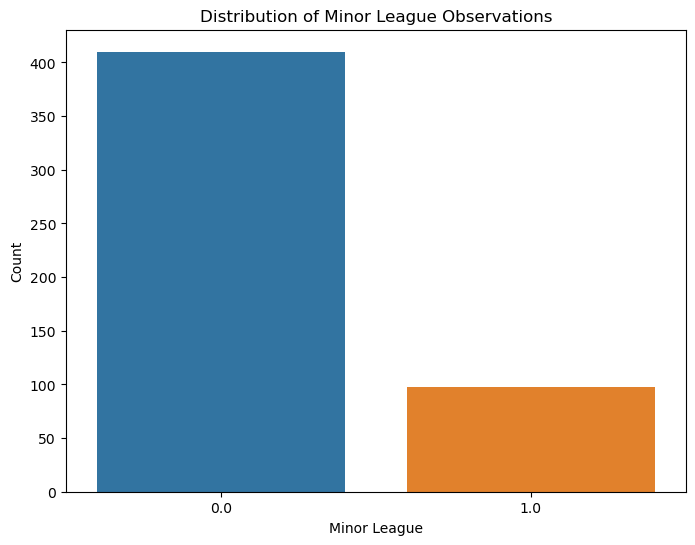

In [46]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df6, x='minor_league')
plt.title('Distribution of Minor League Observations')
plt.xlabel('Minor League')
plt.ylabel('Count')

plt.show()


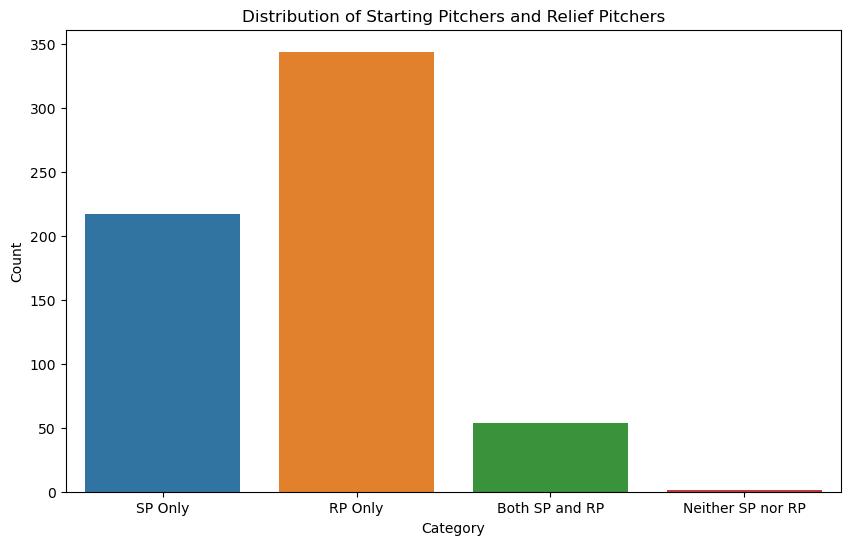

In [47]:
sp_count = (df6['SP'] == 1).sum()
rp_count = (df6['RP'] == 1).sum()
both_count = ((df6['SP'] == 1) & (df6['RP'] == 1)).sum()
none_count = ((df6['SP'] != 1) & (df6['RP'] != 1)).sum()

data = {
    'Category': ['SP Only', 'RP Only', 'Both SP and RP', 'Neither SP nor RP'],
    'Count': [sp_count, rp_count, both_count, none_count]
}
count_df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=count_df)

plt.title('Distribution of Starting Pitchers and Relief Pitchers')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()


In [48]:
neither_df = df6[(df6['SP'] != 1) & (df6['RP'] != 1)]
neither_df.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
771,Brett Cecil,2017,4,30.5,7.625,0.0,0.0,0.0,STL,TOR,...,54.1,70.0,11.6,2.15,0.66,0.516,0.19,0.294,92.3,90.3


In [49]:
print(neither_df[['G', 'GS', 'G_2', 'GS_2']])

        G   GS   G_2  GS_2
771  54.0  0.0  63.0   0.0


We can clearly see here that he is a RP

In [50]:
df6.loc[(df6['Name'] == 'Brett Cecil') & (df6['year'] == 2017), 'RP'] = 1

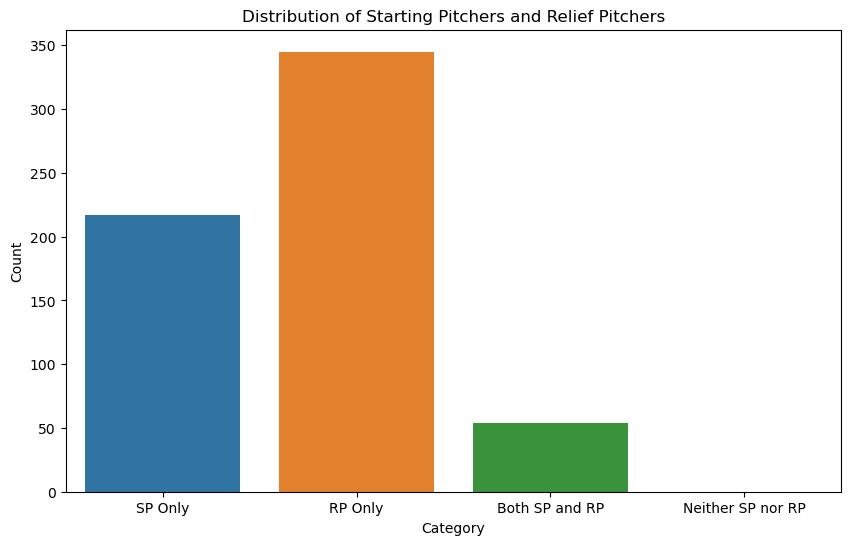

In [51]:
sp_count2 = (df6['SP'] == 1).sum()
rp_count2 = (df6['RP'] == 1).sum()
both_count2 = ((df6['SP'] == 1) & (df6['RP'] == 1)).sum()
none_count2 = ((df6['SP'] != 1) & (df6['RP'] != 1)).sum()

data2 = {
    'Category': ['SP Only', 'RP Only', 'Both SP and RP', 'Neither SP nor RP'],
    'Count': [sp_count2, rp_count2, both_count2, none_count2]
}
count_df2 = pd.DataFrame(data2)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=count_df2)

plt.title('Distribution of Starting Pitchers and Relief Pitchers')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()


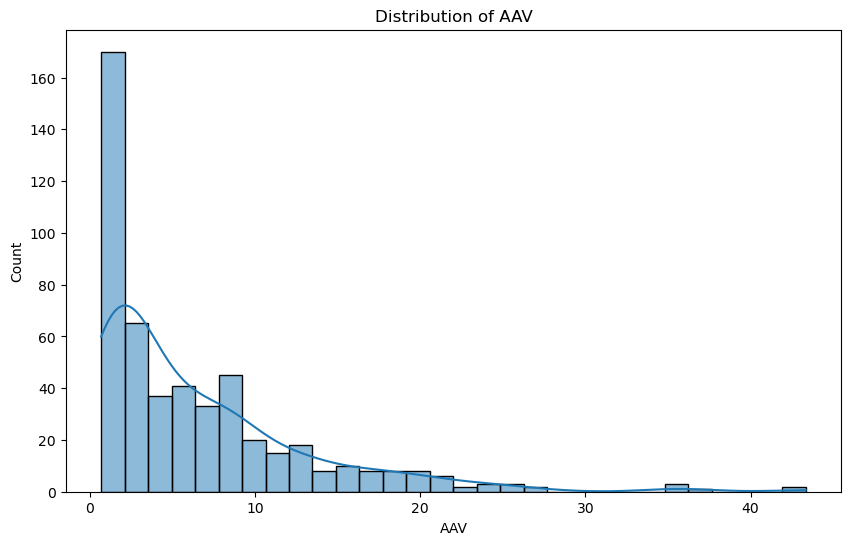

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(df6['AAV'], bins=30, kde=True)

plt.title('Distribution of AAV')
plt.xlabel('AAV')
plt.ylabel('Count')

plt.show()

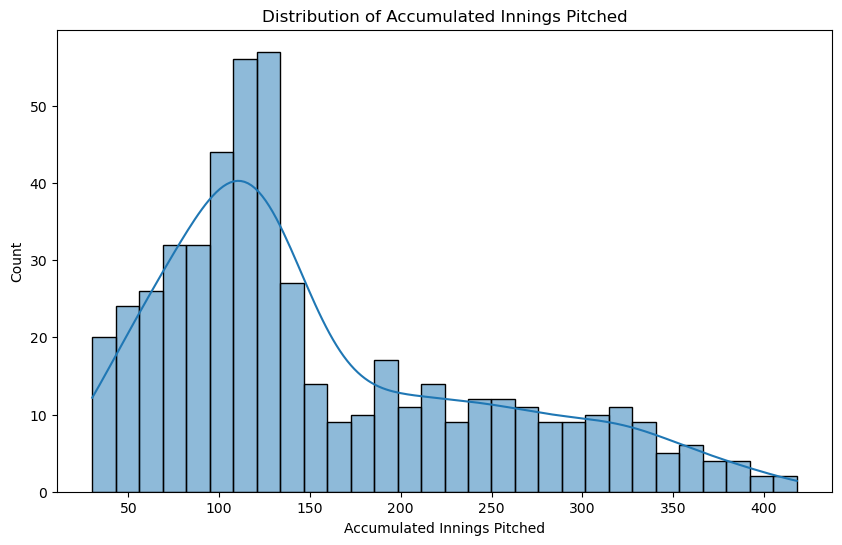

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(df6['Accumulated_IP'], bins=30, kde=True)

plt.title('Distribution of Accumulated Innings Pitched')
plt.xlabel('Accumulated Innings Pitched')
plt.ylabel('Count')

plt.show()

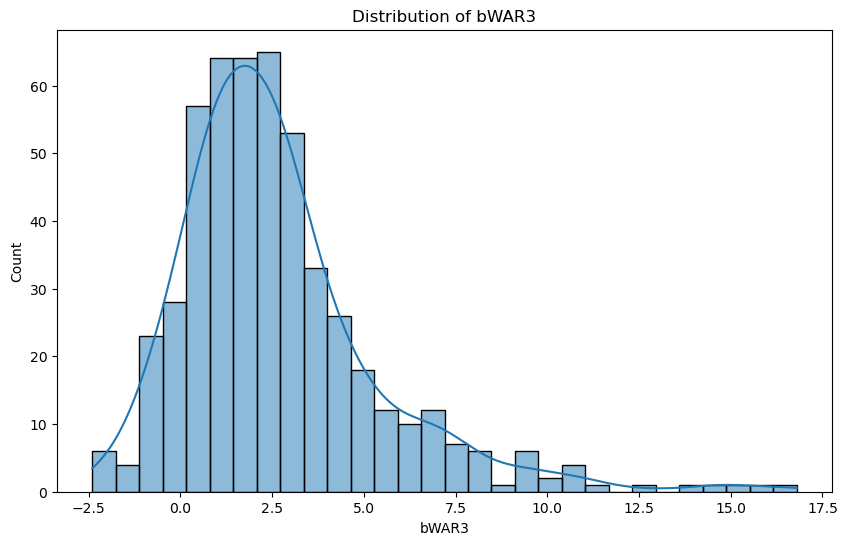

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(df6['bWAR3'], bins=30, kde=True)

plt.title('Distribution of bWAR3')
plt.xlabel('bWAR3')
plt.ylabel('Count')

plt.show()

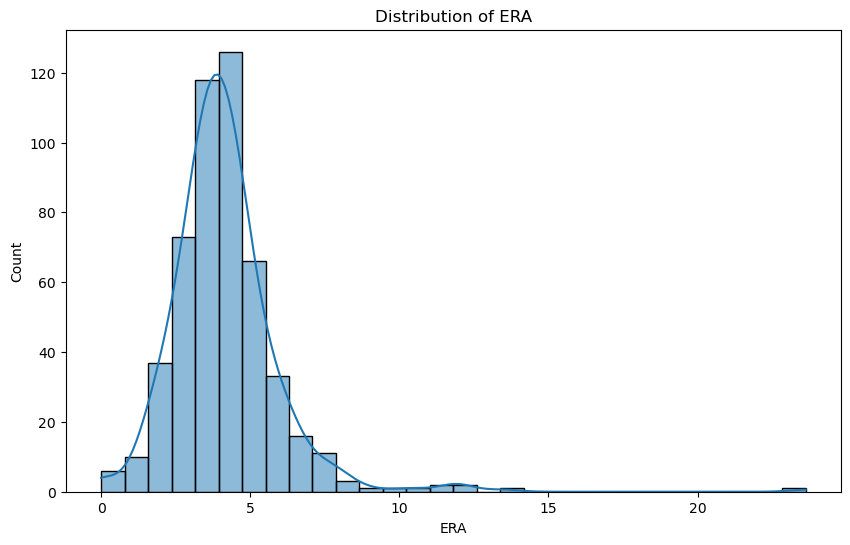

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df6['ERA'], bins=30, kde=True)

plt.title('Distribution of ERA')
plt.xlabel('ERA')
plt.ylabel('Count')

plt.show()

In [56]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   contract_years    508 non-null    int64  
 3   salary            508 non-null    float64
 4   AAV               508 non-null    float64
 5   minor_league      508 non-null    float64
 6   SP                508 non-null    float64
 7   RP                508 non-null    float64
 8   new_team          508 non-null    object 
 9   former_team       508 non-null    object 
 10  Age               508 non-null    int64  
 11  bWAR3             508 non-null    float64
 12  Yrs               508 non-null    int64  
 13  stayed_same_team  508 non-null    float64
 14  W                 508 non-null    float64
 15  L                 508 non-null    float64
 16  ERA               508 non-null    float64
 

In [57]:
boolean_columns = ['SP', 'RP', 'minor_league', 'stayed_same_team']
df6[boolean_columns] = df6[boolean_columns].astype(bool)


In [58]:
df7=df6.copy()

### Interest Rates

In [59]:
df7.loc[df7['year'] == 2024, 'AAV'] *= 1
df7.loc[df7['year'] == 2023, 'AAV'] *= 0.994232329
df7.loc[df7['year'] == 2022, 'AAV'] *= 1.097132508
df7.loc[df7['year'] == 2020, 'AAV'] *= 1.187629677
df7.loc[df7['year'] == 2019, 'AAV'] *= 1.188733275
df7.loc[df7['year'] == 2018, 'AAV'] *= 1.183309539
df7.loc[df7['year'] == 2017, 'AAV'] *= 1.171102114
df7.loc[df7['year'] == 2016, 'AAV'] *= 1.231297408
df7.head()

,Name,year,contract_years,salary,AAV,minor_league,SP,RP,new_team,former_team,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
0,Jay Jackson,2024,1,1.50,1.500000,False,False,True,MIN,TOR,...,1.1,1.0,6.750002,0.000000,0.000000,0.000000,0.333333,0.666667,92.600000,30.3
6,Shelby Miller,2024,1,3.25,3.250000,False,False,True,DET,LAD,...,7.0,14.0,18.000002,3.857143,0.000000,0.153846,0.384615,0.461538,94.421053,49.0
9,Noah Syndergaard,2023,1,13.00,12.925020,False,True,False,LAD,PHI,...,2.0,2.0,9.000000,0.000000,4.500000,0.166667,0.333333,0.500000,94.733333,136.2
15,Sean Doolittle,2023,1,1.50,1.491348,True,False,True,WSN,WSN,...,49.2,53.0,9.604029,4.167786,1.268457,0.190141,0.267606,0.542254,93.139601,54.3
16,Tyler Clippard,2020,1,2.75,3.265982,False,False,True,MIN,CLE,...,68.2,85.0,11.140778,3.014564,1.703884,0.191860,0.203488,0.604651,90.926531,130.2


### Feature Selection

In [60]:
removed_columns = ['salary', 'contract_years', 'MLBAMID', 'new_team', 'former_team', 'bWAR3']
selected_columns = df7.columns[~df7.columns.isin(removed_columns)]


In [61]:
df7 = df7.drop(columns=removed_columns).copy()

df7.head()

,Name,year,AAV,minor_league,SP,RP,Age,Yrs,stayed_same_team,W,...,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,GB%_2,LD%_2,FB%_2,FBv_2,Accumulated_IP
0,Jay Jackson,2024,1.500000,False,False,True,36,5,False,3.0,...,1.1,1.0,6.750002,0.000000,0.000000,0.000000,0.333333,0.666667,92.600000,30.3
6,Shelby Miller,2024,3.250000,False,False,True,33,11,False,3.0,...,7.0,14.0,18.000002,3.857143,0.000000,0.153846,0.384615,0.461538,94.421053,49.0
9,Noah Syndergaard,2023,12.925020,False,True,False,30,7,False,10.0,...,2.0,2.0,9.000000,0.000000,4.500000,0.166667,0.333333,0.500000,94.733333,136.2
15,Sean Doolittle,2023,1.491348,True,False,True,36,11,True,0.0,...,49.2,53.0,9.604029,4.167786,1.268457,0.190141,0.267606,0.542254,93.139601,54.3
16,Tyler Clippard,2020,3.265982,False,False,True,35,13,False,1.0,...,68.2,85.0,11.140778,3.014564,1.703884,0.191860,0.203488,0.604651,90.926531,130.2


In [62]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              508 non-null    object 
 1   year              508 non-null    int64  
 2   AAV               508 non-null    float64
 3   minor_league      508 non-null    bool   
 4   SP                508 non-null    bool   
 5   RP                508 non-null    bool   
 6   Age               508 non-null    int64  
 7   Yrs               508 non-null    int64  
 8   stayed_same_team  508 non-null    bool   
 9   W                 508 non-null    float64
 10  L                 508 non-null    float64
 11  ERA               508 non-null    float64
 12  WHIP              508 non-null    float64
 13  G                 508 non-null    float64
 14  GS                508 non-null    float64
 15  QS                508 non-null    float64
 16  SV                508 non-null    float64
 

#### Correlation Matrix

In [63]:
numerical_columns = df7.select_dtypes(include=['number']).columns
boolean_columns = df7.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df7[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)


,AAV,Accumulated_IP,Age,BB/9,BB/9_2,BS,BS_2,ERA,ERA_2,FB%,FB%_2,FBv,FBv_2,G,GB%,GB%_2,GS,GS_2,G_2,HLD,HLD_2,HR/9,HR/9_2,IP,IP_2,K/9,K/9_2,L,LD%,LD%_2,L_2,PlayerId,QS,QS_2,RP,SO,SO_2,SP,SV,SV_2,W,WHIP,WHIP_2,W_2,Yrs,minor_league,stayed_same_team,year
AAV,1.000000,0.520056,0.017650,-0.233117,-0.186281,-0.093451,-0.157158,-0.268117,-0.139335,-0.007338,0.033875,0.113450,0.157481,-0.055656,0.025958,-0.020673,0.519264,0.374161,-0.164019,-0.164574,-0.237728,-0.140803,-0.029122,0.571719,0.314843,0.305915,0.283678,0.310883,-0.035103,-0.027283,0.228153,0.015128,0.642682,0.417008,-0.503318,0.720249,0.496335,0.408327,0.137674,0.068189,0.621211,-0.331762,-0.226860,0.377868,0.146390,-0.351841,0.005585,0.057759
Accumulated_IP,0.520056,1.000000,0.021055,-0.183798,-0.188862,-0.323258,-0.403507,0.019992,0.017067,-0.012083,-0.009420,0.054952,-0.208084,-0.222325,-0.011348,0.002899,0.840654,0.841476,-0.266887,-0.338316,-0.364157,0.116713,0.084823,0.840641,0.853954,-0.154101,-0.085575,0.677465,0.052355,0.013612,0.649765,-0.098142,0.795062,0.810333,-0.657816,0.753452,0.768905,0.709897,-0.169418,-0.216273,0.691315,-0.026935,-0.050580,0.715853,0.206981,-0.299935,0.003877,-0.069581
Age,0.017650,0.021055,1.000000,-0.142736,-0.097030,0.134614,0.054445,-0.259007,-0.150214,0.106590,0.102448,0.006860,-0.265346,0.172871,-0.053884,-0.066705,0.000955,-0.058704,0.089508,0.130784,0.093550,-0.171954,-0.014752,0.061453,-0.024057,0.046737,0.041308,-0.028941,-0.125416,-0.073392,-0.112250,-0.475192,0.039334,0.001423,-0.031667,0.042873,-0.026721,-0.110957,0.073274,0.058085,0.103556,-0.244740,-0.151804,0.026578,0.712520,-0.113280,0.102823,0.005847
BB/9,-0.233117,-0.183798,-0.142736,1.000000,0.393469,0.088675,0.170539,0.429505,0.037150,-0.157145,0.008056,-0.012537,0.196749,0.028399,0.056497,0.024751,-0.183914,-0.135325,0.146356,0.050386,0.091071,0.007204,-0.054368,-0.214108,-0.099693,0.128015,0.112868,-0.038901,0.231530,-0.071678,-0.030651,0.132995,-0.221516,-0.145949,0.186020,-0.196256,-0.098651,-0.149976,0.025821,0.090453,-0.226887,0.591082,0.118289,-0.053595,-0.143035,0.150704,-0.102600,0.067862
BB/9_2,-0.186281,-0.188862,-0.097030,0.393469,1.000000,0.030119,0.079376,0.149551,0.259522,-0.026321,-0.039106,0.004663,0.226581,0.070649,0.019680,0.052094,-0.129345,-0.173645,0.058181,0.095525,0.066104,-0.010883,0.014464,-0.131516,-0.187460,0.186627,0.124696,-0.076726,0.018097,-0.030551,-0.059958,0.041236,-0.163580,-0.229060,0.206825,-0.085563,-0.193020,-0.148936,-0.013506,-0.003348,-0.147569,0.176671,0.554360,-0.203116,-0.078267,0.070286,-0.056294,0.040413
BS,-0.093451,-0.323258,0.134614,0.088675,0.030119,1.000000,0.571965,-0.161835,-0.212256,0.090520,0.060850,-0.018960,0.195404,0.718579,-0.043698,-0.009469,-0.495260,-0.489847,0.530379,0.545138,0.368326,-0.120812,-0.153893,-0.241939,-0.304683,0.272678,0.258706,-0.127039,-0.108157,-0.109606,-0.216613,-0.052389,-0.422445,-0.429619,0.463009,-0.180036,-0.232339,-0.548262,0.599303,0.502361,-0.181963,-0.124355,-0.190186,-0.249533,0.023554,-0.078808,-0.057319,-0.015856
BS_2,-0.157158,-0.403507,0.054445,0.170539,0.079376,0.571965,1.000000,-0.061436,-0.231010,0.129275,0.102282,-0.017036,0.335198,0.529813,-0.105041,-0.079018,-0.516031,-0.581791,0.743197,0.449250,0.548373,-0.042513,-0.169486,-0.360689,-0.323935,0.245035,0.359486,-0.266087,-0.072125,-0.045295,-0.174995,-0.038182,-0.436225,-0.501489,0.470027,-0.274722,-0.228842,-0.582721,0.391300,0.566843,-0.287209,-0.067396,-0.163523,-0.217295,-0.026585,0.006667,-0.108330,-0.002757
ERA,-0.268117,0.019992,-0.259007,0.429505,0.149551,-0.161835,-0.061436,1.000000,0.087966,-0.066165,-0.052751,-0.051050,0.018948,-0.300982,-0.114917,0.071294,0.020778,0.147052,-0.058244,-0.227700,-0.047255,0.535689,0.007186,-0.109145,0.138083,-0.194607,-0.169533,0.114317,0.378240,-0.043764,0.158630,0.152641,-0.077033,0.119318,-0.017824,-0.191722,0.057745,0.103701,-0.183780,-0.104152,-0.190669,0.806564,0.138912,0.101478,-0.250869,0.122744,-0.083995,-0.020878
ERA_2,-0.139335,0.017067,-0.150214,0.037150,0.259522

I expected LD%, GB%, and FB% to be irrelevant but I wanted to add them to see their behavior. 

Age seemed to be a non factor compared to the batters. We can see more pitchers get to their late 30s and still be at their peak level (Scherzer, Verlander, Greinke). 

We can also see that it didn't matter if the player stayed in the same team when signing their contract, sort of a similar behavior for batters. 

For starters I see more significant negative correlations than in the batters df. 

Before I start dropping columns, I will download this dataframe to a csv file for the next step, which is the advanced analytics part. 

## DF TO CSV

In [64]:
df7.to_csv('pitchers_nb.csv', index=False)

In [65]:
columns_to_drop = ['LD%', 'LD%_2','FB%','FB%_2','GB%','GB%_2','Age','PlayerId','stayed_same_team','year']

df8 = df7.drop(columns=columns_to_drop)

df8.head()

,Name,AAV,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,...,SV_2,BS_2,HLD_2,IP_2,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP
0,Jay Jackson,1.500000,False,False,True,5,3.0,1.0,2.123596,0.910112,...,0.0,0.0,0.0,1.1,1.0,6.750002,0.000000,0.000000,92.600000,30.3
6,Shelby Miller,3.250000,False,False,True,11,3.0,0.0,1.714286,0.904762,...,0.0,0.0,1.0,7.0,14.0,18.000002,3.857143,0.000000,94.421053,49.0
9,Noah Syndergaard,12.925020,False,True,False,7,10.0,10.0,3.943070,1.254951,...,0.0,0.0,0.0,2.0,2.0,9.000000,0.000000,4.500000,94.733333,136.2
15,Sean Doolittle,1.491348,True,False,True,11,0.0,0.0,0.000000,0.187500,...,1.0,4.0,5.0,49.2,53.0,9.604029,4.167786,1.268457,93.139601,54.3
16,Tyler Clippard,3.265982,False,False,True,13,1.0,0.0,2.903227,0.854839,...,7.0,6.0,15.0,68.2,85.0,11.140778,3.014564,1.703884,90.926531,130.2


In [66]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 1076
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            508 non-null    object 
 1   AAV             508 non-null    float64
 2   minor_league    508 non-null    bool   
 3   SP              508 non-null    bool   
 4   RP              508 non-null    bool   
 5   Yrs             508 non-null    int64  
 6   W               508 non-null    float64
 7   L               508 non-null    float64
 8   ERA             508 non-null    float64
 9   WHIP            508 non-null    float64
 10  G               508 non-null    float64
 11  GS              508 non-null    float64
 12  QS              508 non-null    float64
 13  SV              508 non-null    float64
 14  BS              508 non-null    float64
 15  HLD             508 non-null    float64
 16  IP              508 non-null    float64
 17  SO              508 non-null    fl

### Train-test split

In [67]:
target = "AAV"
features = [col for col in df8.columns if col != target and col!= "Name"]
X, y = df8[features], df8[target]

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (355, 37)
X_test shape: (153, 37)
y_train shape: (355,)
y_test shape: (153,)


In [69]:
y_train

156     3.291398
599     0.994232
107     1.783100
697     4.474045
532     4.114247
         ...    
504    13.000000
184    12.427904
755     6.582795
476     1.783100
103     1.097133
Name: AAV, Length: 355, dtype: float64

#### Distribution of y_train values

C:\Users\mfran\AppData\Local\Temp\ipykernel_11024\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


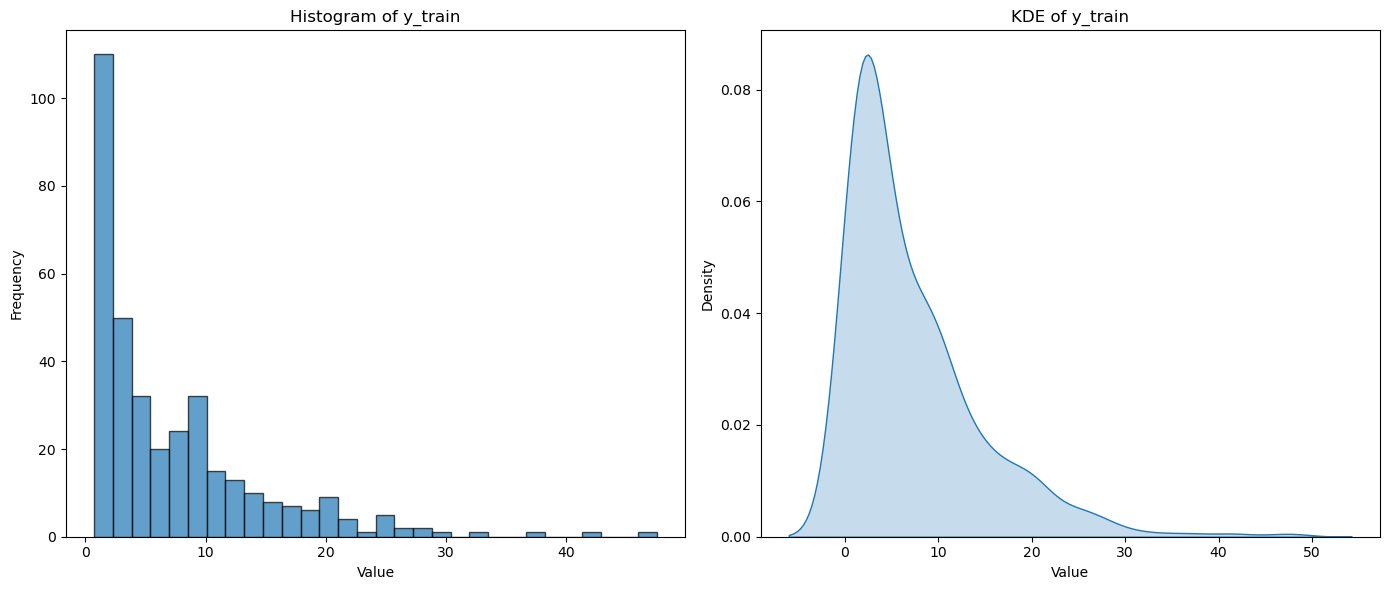

In [70]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Distribution of y_test values 

C:\Users\mfran\AppData\Local\Temp\ipykernel_11024\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


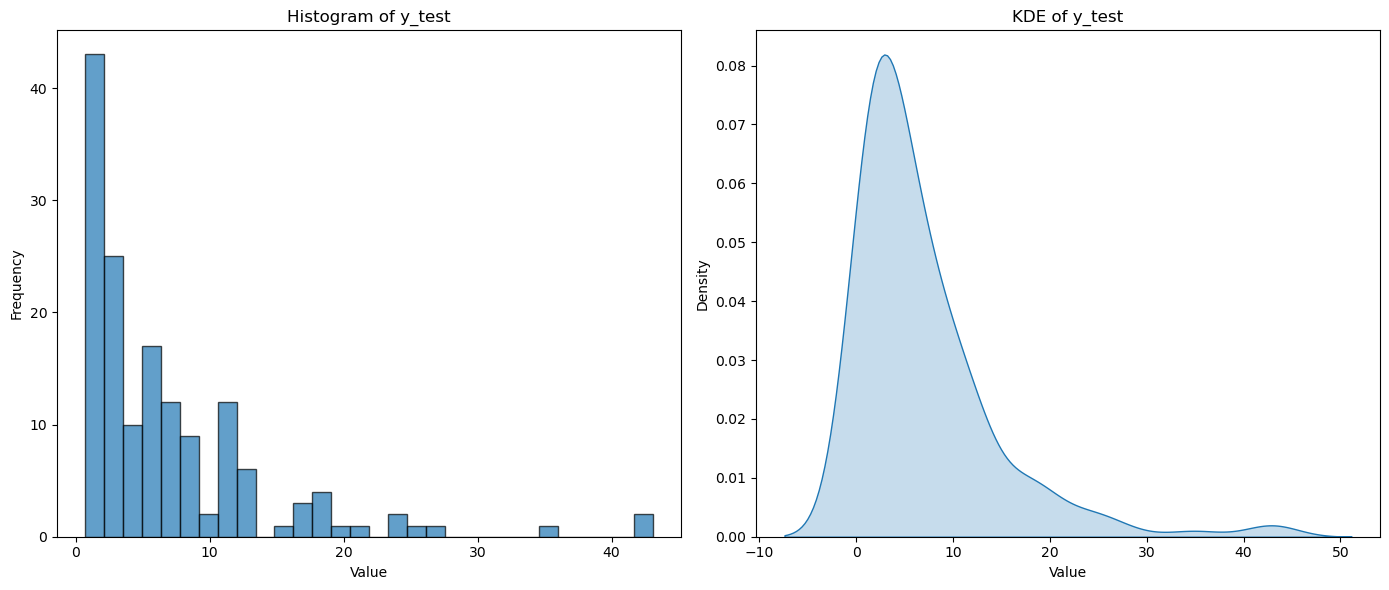

In [71]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Linear Model

In [72]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [73]:
linear_model.coef_, linear_model.intercept_

(array([-1.49288848e+00,  2.55383027e-01, -2.65414974e+00, -1.06808019e-01,
         2.78483359e-02, -2.78566810e-01,  2.10774370e-01, -2.34767083e+00,
        -1.25580541e-01, -3.38819087e-01,  4.91267921e-01,  2.02890880e-01,
        -2.29647879e-02,  2.09547495e-01,  1.06300236e-02,  9.33025396e-02,
         1.30834911e-01, -1.79243580e-01, -2.28293710e-01, -9.09362923e-03,
        -8.89224181e-02,  4.20927629e-02,  2.96842197e-02, -6.85240059e-01,
        -1.74381875e-02, -1.20068315e-01,  1.59034980e-01,  5.00517813e-02,
        -1.05860980e-01, -1.86734276e-02,  2.91407487e-03, -3.25355591e-05,
         3.04920796e-01, -2.77343799e-01, -4.02836924e-01,  2.01274210e-01,
         1.35440985e-02]),
 -9.607306422643845)

In [74]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,8.755822,-2.817674,-47.450376
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,14.482109,-5.311460,-57.918041
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,14.852347,2.049602,12.126426
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,5.015239,-3.469886,-224.536743
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,-0.328561,3.071392,111.978900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,19.869322,-2.830811,-16.614196
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,11.698473,0.177824,1.497303
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,5.918611,6.506139,52.364346
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,3.428036,3.697742,51.892466


## Evaluation Metrics 

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.641347772000469
MAPE: 0.9389252866981205
R^2: 0.6027790737678542


The RMSE is telling us the average error in the predictions: we are failing by 4.55 on average. The MAPE tells us about the average percentage error, since a variation of 5M is not the same in a player's AAV of 200k than for a 40M player AAV : in our case we are failing by 84% on average. Finally the R^2 score is the Pearson's coefficient of predictions against reality: 1 would be a perfect model, while 0 is the worst possible scenario. 

### Evaluating per ranges

#### Testing 0-5 range values

In [76]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df['y_real_in_range'].sum()

correct_predictions = results_df['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 38


#### All ranges visualized with a bar plot

   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     79                   38
1   5-10                     40                   21
2  10-15                     19                    4
3  15-20                      7                    2
4  20-25                      5                    2
5  25-30                      2                    0
6  30-35                      1                    0
7  35-40                      0                    0
8    40+                      2                    1


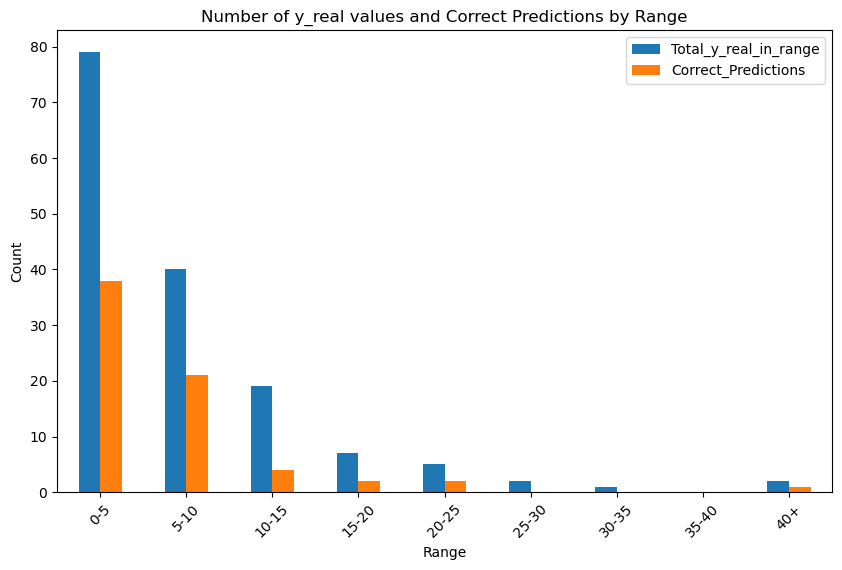

In [77]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

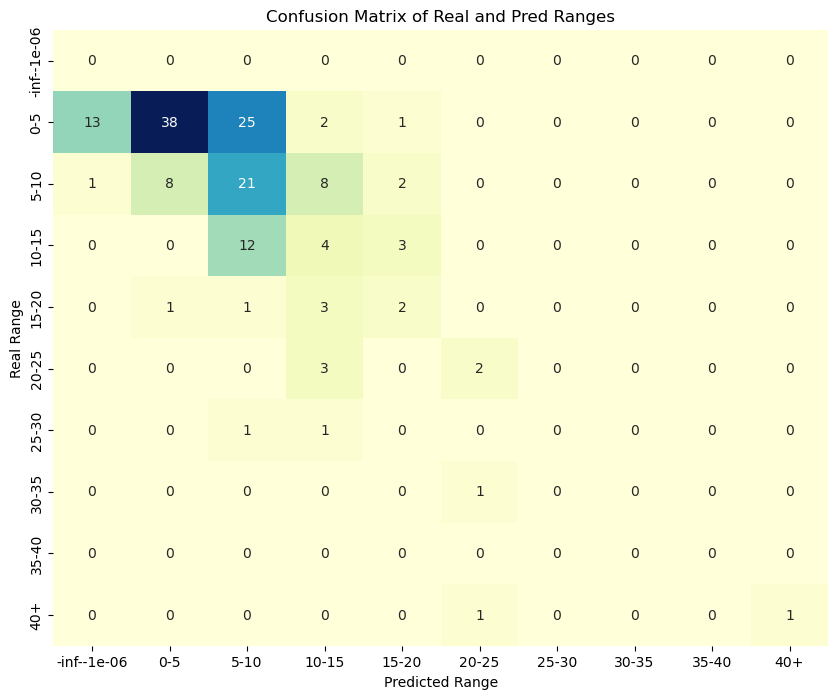

In [78]:
ranges = [(-float('inf'), -0.000001),(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [79]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
-inf--1e-06: 0.00%
0-5: 48.10%
5-10: 52.50%
10-15: 21.05%
15-20: 28.57%
20-25: 40.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 50.00%


#### Correction for negative predictions

In [80]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [81]:
linear_model = LinearRegression()

y_train_log_linear = np.log(y_train)
linear_model.fit(X_train, y_train_log_linear)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,8.775788,-2.837640,-47.786611
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,11.714940,-2.544292,-27.743855
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,15.552061,1.349889,7.986588
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,5.905247,-4.359894,-282.129250
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,1.926848,0.815983,29.749664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,53.828067,-36.789557,-215.920034
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,10.047643,1.828654,15.397508
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,4.977342,7.447408,59.940101
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,3.930562,3.195216,44.840244


In [82]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 6.355007540457319
MAPE: 0.5881019913234788
R^2: 0.2553091147224996


In [83]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


### Evaluating per ranges (Linear Neg Correc)

#### Testing 0-5 range values

In [84]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df['y_real_in_range'].sum()

correct_predictions = results_df['in_range'].sum()

print(f'Number of real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 65


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct_Predictions
0    0-5                   79                   65
1   5-10                   40                   22
2  10-15                   19                    3
3  15-20                    7                    2
4  20-25                    5                    1
5  25-30                    2                    0
6  30-35                    1                    0
7  35-40                    0                    0
8    40+                    2                    1


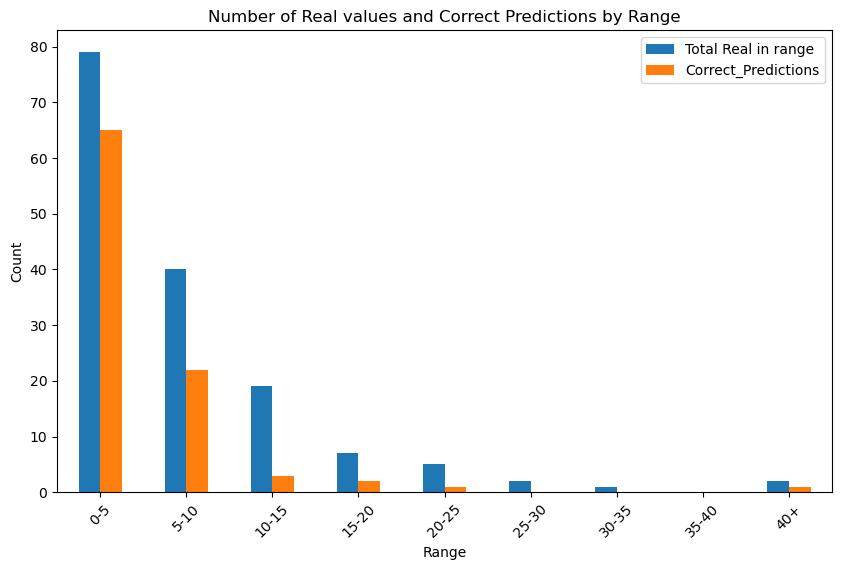

In [85]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

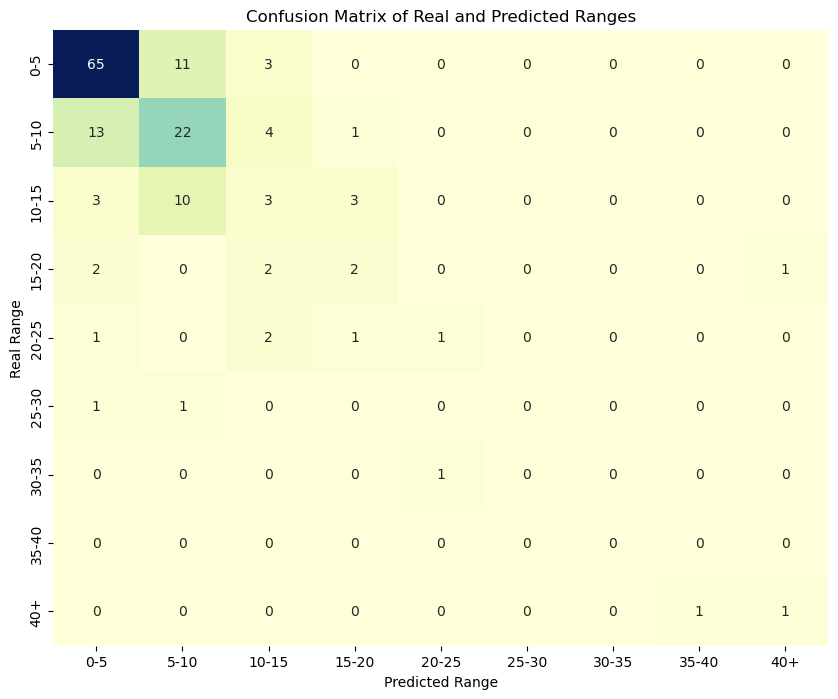

In [86]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [87]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 82.28%
5-10: 55.00%
10-15: 15.79%
15-20: 28.57%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 50.00%


## Ridge Regression

In [88]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,8.737997,-2.799848,-47.150192
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,14.435707,-5.265058,-57.412051
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,14.819532,2.082418,12.320577
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,4.876146,-3.330793,-215.536011
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,-0.313392,3.056223,111.425844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,19.852228,-2.813717,-16.513870
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,11.701259,0.175038,1.473843
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,5.951893,6.472857,52.096479
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,3.366303,3.759475,52.758797


In [89]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 4.6128043927000775
MAPE: 0.9291148424485707
R^2: 0.6076497125542004


#### Testing 0-5 range values

In [90]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 39


   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     79                   39
1   5-10                     40                   21
2  10-15                     19                    4
3  15-20                      7                    2
4  20-25                      5                    2
5  25-30                      2                    0
6  30-35                      1                    0
7  35-40                      0                    0
8    40+                      2                    1


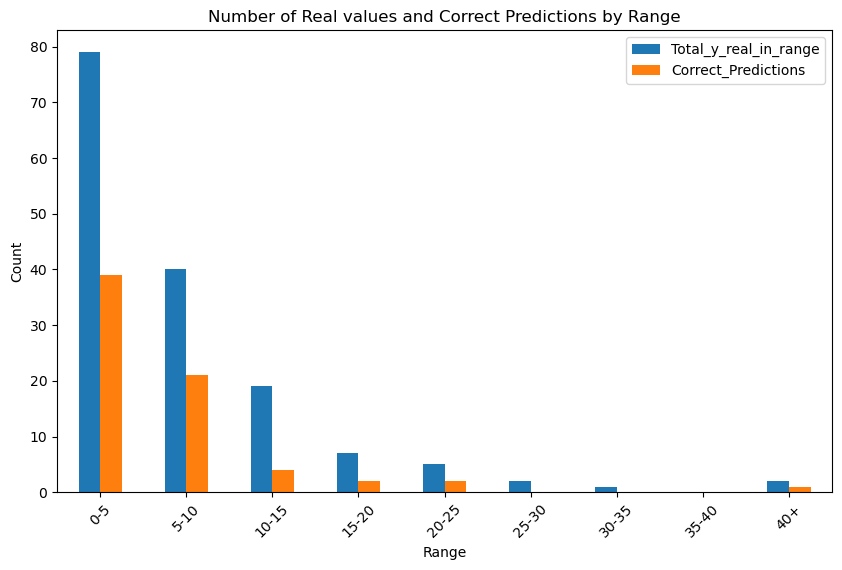

In [91]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

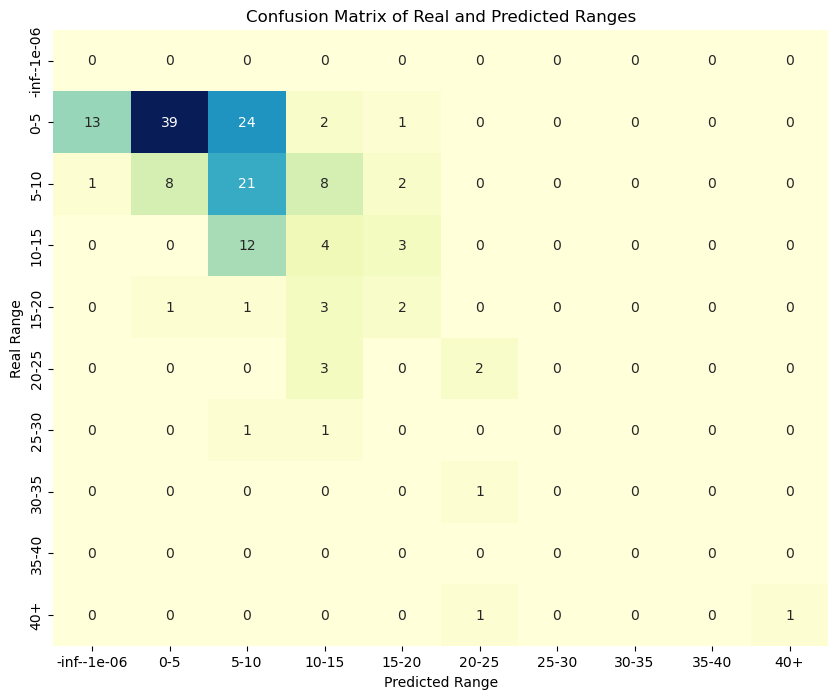

In [92]:
ranges = [(-float('inf'), -0.000001),(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [93]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
-inf--1e-06: 0.00%
0-5: 49.37%
5-10: 52.50%
10-15: 21.05%
15-20: 28.57%
20-25: 40.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 50.00%


### Evaluating per ranges (Ridge neg corr)

#### Correction for negative predictions

In [94]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [95]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log_ridge = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log_ridge)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 6.379233203142474
MAPE: 0.5870626012408284
R^2: 0.2496206820815342


,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,8.731029,-2.792881,-47.032861
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,11.650017,-2.479368,-27.035902
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,15.644319,1.257631,7.440743
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,5.890987,-4.345634,-281.206511
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,1.921936,0.820895,29.928752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,53.309098,-36.270588,-212.874175
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,10.003698,1.872599,15.767531
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,4.842849,7.581901,61.022566
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,3.940270,3.185508,44.704002


#### Testing 0-5 range values

In [96]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 64


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct Predictions
0    0-5                   79                   64
1   5-10                   40                   22
2  10-15                   19                    3
3  15-20                    7                    2
4  20-25                    5                    1
5  25-30                    2                    0
6  30-35                    1                    0
7  35-40                    0                    0
8    40+                    2                    1


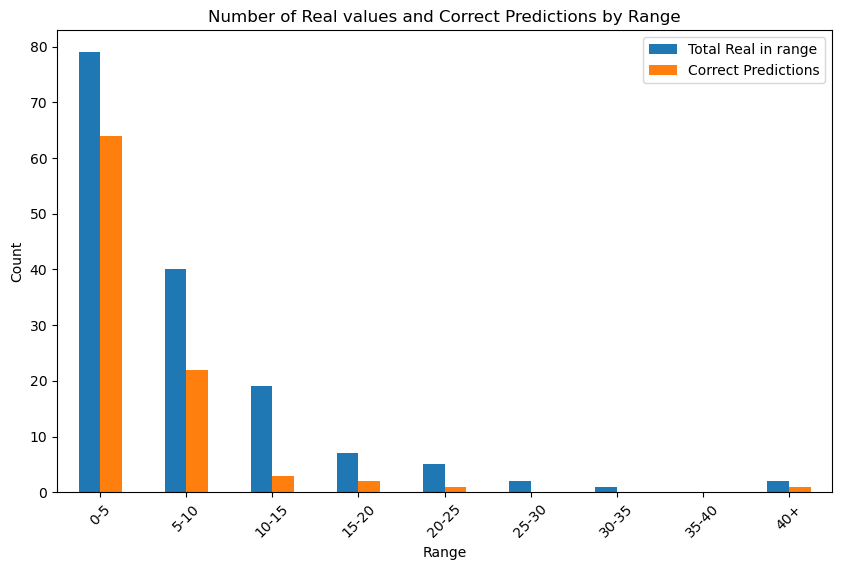

In [97]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

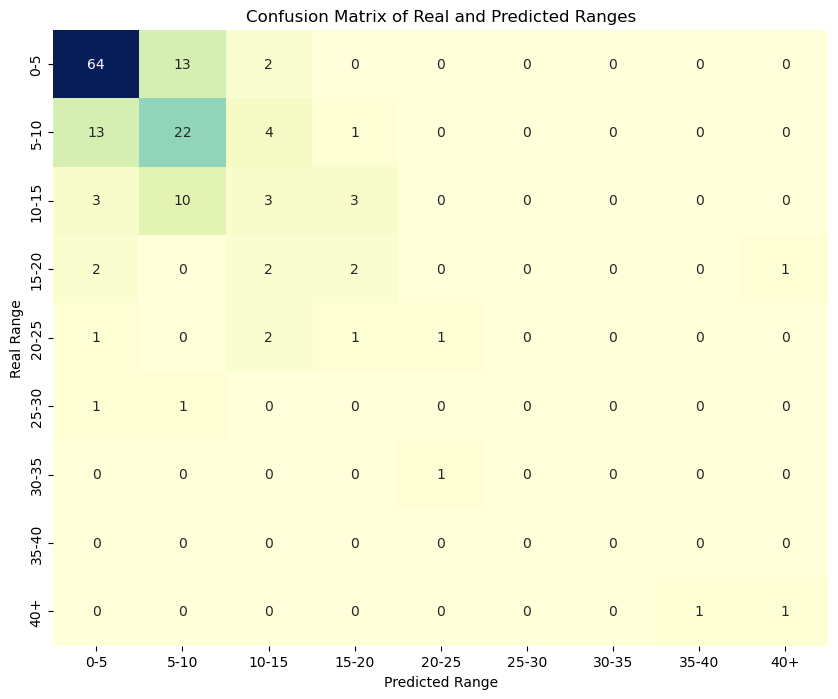

In [98]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [99]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 81.01%
5-10: 55.00%
10-15: 15.79%
15-20: 28.57%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 50.00%


### Min Max Scale

In [100]:
y_train_log = np.log(y_train)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_log)

ridge_y_pred_log = ridge_model.predict(X_test_scaled)

ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge


RMSE: 5.546481711069371
MAPE: 0.5998447276167984
R^2: 0.4327440388609526


,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,9.110792,-3.172644,-53.428169
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,12.574537,-3.403888,-37.117196
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,15.743075,1.158875,6.856458
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,5.908951,-4.363598,-282.368937
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,2.149289,0.593543,21.639781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,32.400631,-15.362121,-90.161173
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,10.404662,1.471635,12.391360
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,4.240541,8.184209,65.870213
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,4.124097,3.001681,42.124251


The model was trained with a MinMaxScale. 

The model performed slightly better than our non scaled version. 


#### Testing 0-5 range values

In [101]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 64


#### All ranges visualized with a bar plot

   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     78                   64
1   5-10                     40                   23
2  10-15                     19                    3
3  15-20                      7                    2
4  20-25                      4                    1
5  25-30                      2                    0
6  30-35                      1                    0
7  35-40                      0                    0
8    40+                      2                    1


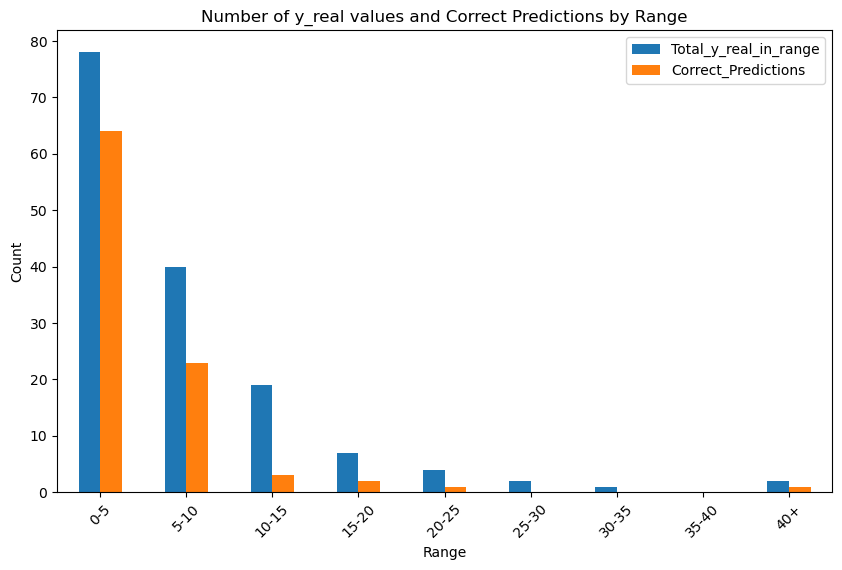

In [102]:
def in_range(y_real, y_pred, range_min, range_max):
    if range_max == float('inf'):
        return range_min <= y_real and range_min <= y_pred
    else:
        return range_min <= y_real < range_max and range_min <= y_pred < range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y < range_max if range_max != float('inf') else range_min <= y)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Confusion Matrix

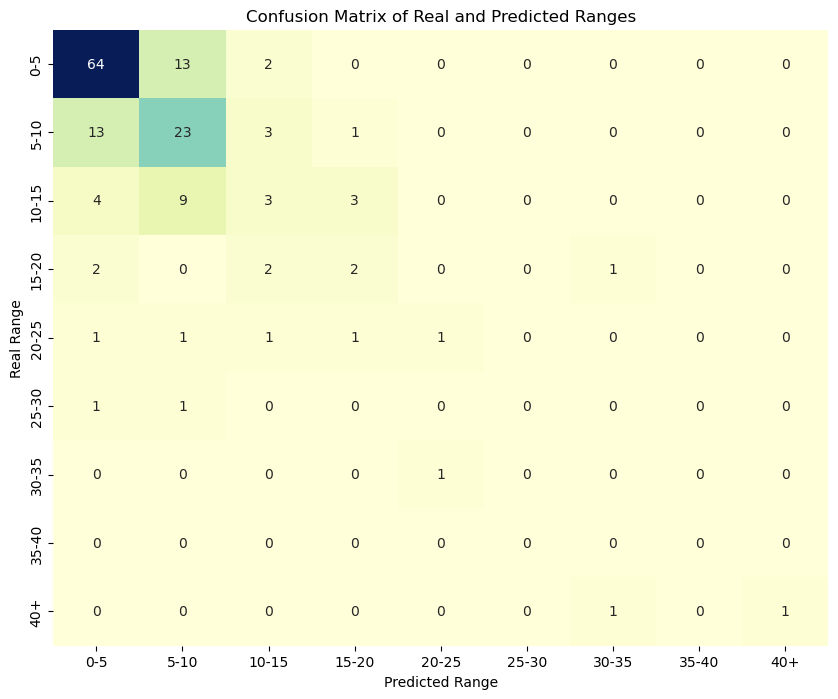

In [103]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [104]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 81.01%
5-10: 57.50%
10-15: 15.79%
15-20: 28.57%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 50.00%


### XGBoost Regression

In [105]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,SO_2,K/9_2,BB/9_2,HR/9_2,FBv_2,Accumulated_IP,y_real,y_pred,err,%_err
847,False,True,False,11,13.0,9.0,3.886364,1.306818,31.0,31.0,...,47.0,5.265560,1.456432,1.120332,90.338384,256.10,5.938148,6.895765,-0.957616,-16.126516
664,False,True,False,9,13.0,10.0,3.890000,1.270000,32.0,32.0,...,119.0,7.440000,3.440000,0.870000,90.800000,324.10,9.170649,10.944011,-1.773362,-19.337364
119,False,True,False,6,14.0,5.0,3.907895,1.127820,32.0,32.0,...,140.0,8.729792,2.743649,1.496536,94.006902,321.20,16.901950,9.946235,6.955715,41.153329
170,False,True,False,9,5.0,3.0,3.450000,1.070000,19.0,19.0,...,96.0,5.270000,2.580000,1.920000,90.200000,255.10,1.545353,6.876451,-5.331098,-344.975994
694,False,False,True,14,4.0,4.0,4.991598,1.386555,50.0,0.0,...,22.0,7.920002,1.800000,0.720000,87.989899,64.20,2.742831,2.555782,0.187050,6.819583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,False,False,True,9,5.0,1.0,2.740000,0.990000,63.0,0.0,...,126.0,16.430000,1.830000,0.780000,98.300000,62.79,17.038510,21.232998,-4.194488,-24.617690
282,False,True,False,11,14.0,12.0,5.520000,1.390000,32.0,32.0,...,60.0,9.360000,2.340000,1.560000,92.300000,231.30,11.876297,7.998554,3.877743,32.651112
514,False,False,True,11,6.0,0.0,2.061069,0.916031,45.0,0.0,...,8.0,4.500002,1.687501,1.125000,94.220183,59.20,12.424750,4.672848,7.751902,62.390807
72,False,False,True,10,4.0,6.0,2.950000,1.200000,70.0,0.0,...,66.0,9.530000,2.020000,2.170000,94.200000,126.10,7.125778,3.506731,3.619047,50.788100


In [106]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.224962388141894
MAPE: 0.8000142430058828
R^2: 0.6708532342049567


In [107]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


#### Testing 0-5 range values

In [108]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 79
Number of correct predictions in the range 0-5: 52


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct Predictions
0    0-5                   78                   52
1   5-10                   40                   21
2  10-15                   19                    5
3  15-20                    7                    1
4  20-25                    4                    0
5  25-30                    2                    0
6  30-35                    1                    0
7  35-40                    0                    0
8    40+                    2                    0


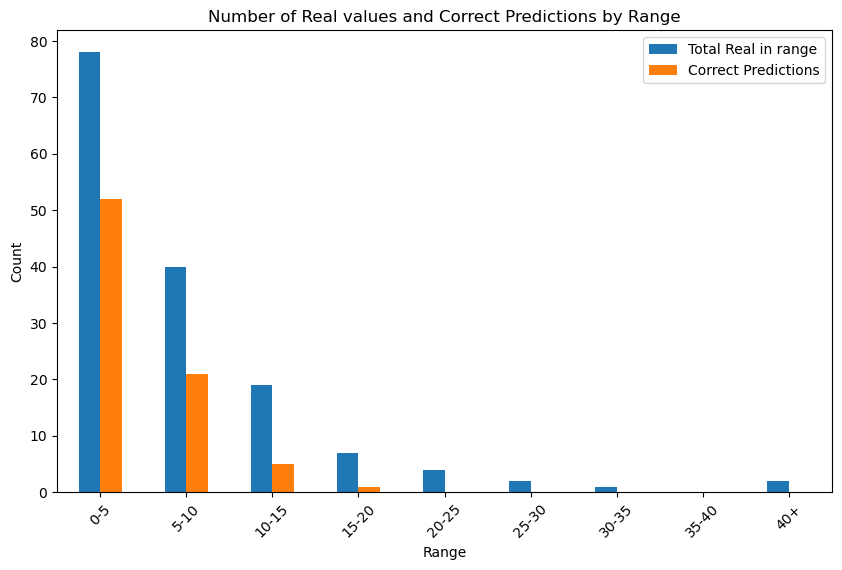

In [109]:
ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    if range_max == float('inf'):
        return range_min <= y_real and range_min <= y_pred
    else:
        return range_min <= y_real < range_max and range_min <= y_pred < range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y < range_max if range_max != float('inf') else range_min <= y)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Confusion Matrix

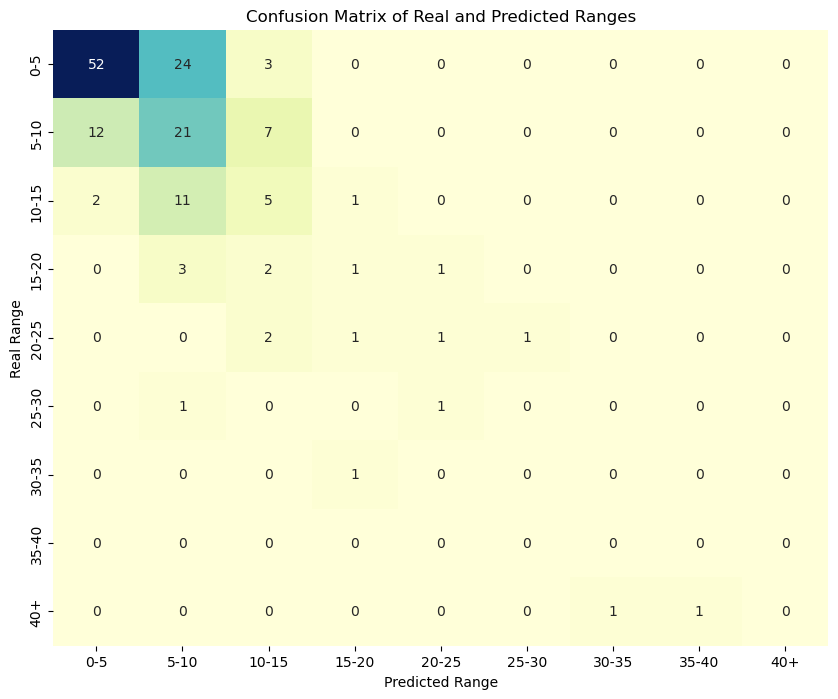

In [110]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_xgb['y_real'] >= real_range_min) & (results_df_xgb['y_real'] <= real_range_max) &
                 (results_df_xgb['y_pred'] >= pred_range_min) & (results_df_xgb['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [111]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 65.82%
5-10: 52.50%
10-15: 26.32%
15-20: 14.29%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%
